__Import libraries for image preprocessing and Tensorflow framework with Keras API for creating model.__

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import Layer, RandomFlip, Conv2D, Conv2DTranspose, Concatenate, BatchNormalization, Activation, MaxPool2D, Input
import warnings

In [2]:
warnings.filterwarnings('ignore')
np.set_printoptions(suppress = True)
%matplotlib inline

__Load Oxford-IIIT Pet Dataset.__

In [3]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info = True)

2023-12-08 21:16:11.963066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 21:16:11.993945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 21:16:11.993992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 21:16:11.996324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 21:16:11.996369: I tensorflow/compile

In [4]:
dataset['train']

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [5]:
# define method for extracting and normalizing images
IMAGE_SHAPE = (128,128)
def extract_images_and_masks(features: list):
    image = tf.image.resize(images = features['image'], size = (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
    mask = tf.image.resize(images = features['segmentation_mask'], size = (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
    # normalize
    image = tf.cast(image, tf.float32) / 255
    # for convenience, we are converting segmenation mask into [0,1,2] class labels by substracting 1 from [1,2,3]
    mask -= 1
    # convert to one-hot encoded labels
    mask = tf.one_hot(tf.cast(tf.squeeze(mask, axis = -1), tf.int32), depth = 3)
    return image, mask

# dataset already contains information about train and test, let's extract information from info
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16 # batch size is small due my GPU have only 4 GB of VRAM :(
BUFFER_SIZE = 500 # same with this
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
print(f'Steps per epoch: {STEPS_PER_EPOCH}')

Steps per epoch: 230


In [6]:
# define Augment class for prevent overfitting by using image augmenatation
class Augment(Layer):
    def __init__(self, seed = 42):
        super().__init__()
        self.augment_inputs = RandomFlip(mode = 'horizontal', seed = seed)
        self.augment_labels = RandomFlip(mode = 'horizontal', seed = seed)
    
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [7]:
# applying our function and create train-test splits
train_images = dataset['train'].map(extract_images_and_masks, num_parallel_calls = tf.data.AUTOTUNE)
test_images = dataset['test'].map(extract_images_and_masks, num_parallel_calls = tf.data.AUTOTUNE)

In [8]:
# define train batches
train_batches = (train_images.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().map(Augment()).prefetch(buffer_size = tf.data.AUTOTUNE))
test_batches = test_images.batch(BATCH_SIZE)

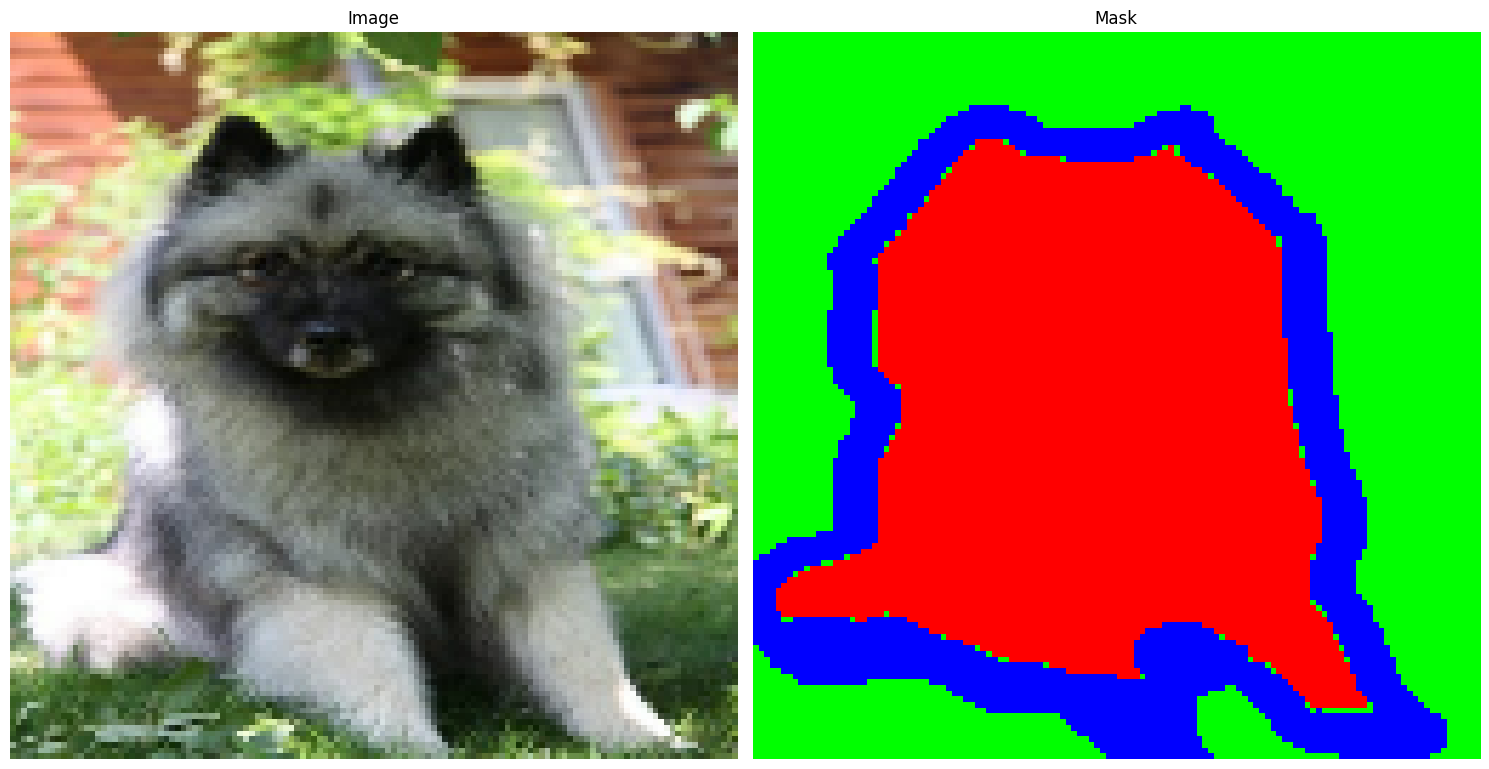

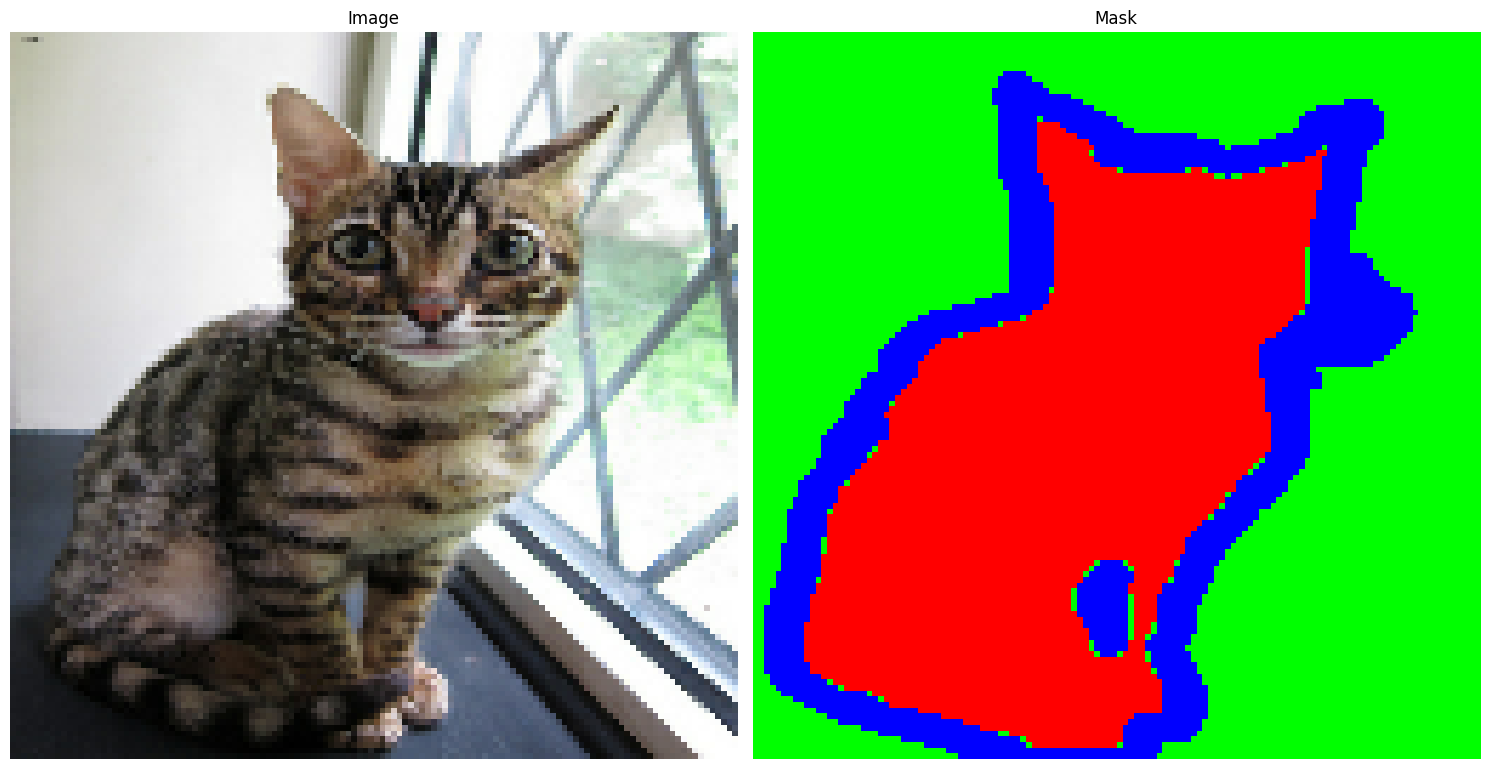

In [19]:
# let's visualize images and corresponding masks
def visualize(vis_list: list):
    plt.figure(figsize = (15,15))
    titles = ['Image', 'Mask', 'Predicted Mask'] # predicted for future
    for i in range(len(vis_list)):
        plt.subplot(1, len(vis_list), i + 1)
        plt.title(titles[i])
        plt.imshow(tf.keras.utils.array_to_img(vis_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show();

for images, masks in train_batches.take(2):
    image, mask = images[0], masks[0]
    visualize([image, mask])

In [10]:
# let's build our U-Net model for segmentation
class UNet:
    def __init__(self):
        self.input_shape = IMAGE_SHAPE + (3,)
    # convolutional block
    def conv_block(self, input, num_filters):
        c = Conv2D(num_filters, 3, padding = 'same')(input)
        c = BatchNormalization()(c)
        c = Activation('relu')(c)

        c = Conv2D(num_filters, 3, padding = 'same')(c)
        c = BatchNormalization()(c)
        c = Activation('relu')(c)

        return c
    # encoding block
    def encoder_block(self, input, num_filters):
        c = self.conv_block(input, num_filters)
        p = MaxPool2D((2,2))(c)

        return c, p
    # decoding block
    def decoder_block(self, input, skip_features, num_filters):
        c = Conv2DTranspose(num_filters, (2,2), strides = 2, padding = 'same')(input) # transopse for de-convulition of images
        c = Concatenate()([c, skip_features]) # concat to image which have been applied convolutional operation
        c = self.conv_block(c, num_filters)
        return c
    
    def unet(self):
        # input
        inputs = Input(self.input_shape)
        # encoders
        c1, p1 = self.encoder_block(inputs, 32)
        c2, p2 = self.encoder_block(p1, 64)
        c3, p3 = self.encoder_block(p2, 128)
        c4, p4 = self.encoder_block(p3, 128)
        # convolutional block
        b1 = self.conv_block(p4, 128)
        # decoders
        d1 = self.decoder_block(b1, c4, 128)
        d2 = self.decoder_block(d1, c3, 128)
        d3 = self.decoder_block(d2, c2, 64)
        d4 = self.decoder_block(d3, c1, 32)
        # output
        outputs = Conv2D(3, 1, padding = 'same')(d4)
        unet_model = Model(inputs, outputs, name = 'U-Net')
        return unet_model
    
    def call(self):
        return self.unet()

In [11]:
# call U-Net model and fit the training batch there
model = UNet().call()
model.compile(
    optimizer = 'adam',
    loss = keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = 'accuracy'
)
history = model.fit(train_batches, epochs = 20, steps_per_epoch = STEPS_PER_EPOCH)

Epoch 1/20


2023-12-08 21:16:17.346623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-08 21:16:17.657417: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-08 21:16:18.014712: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-08 21:16:20.056254: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fad2b866910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-08 21:16:20.056309: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-12-08 21:16:20.062561: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-08 21:16:20.139837: I ./tensorflow/compiler/j

  4/230 [..............................] - ETA: 18s - loss: 1.1314 - accuracy: 0.4182

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


230/230 [==============================] - 33s 83ms/step - loss: 0.6209 - accuracy: 0.7496
Epoch 2/20
230/230 [==============================] - 19s 84ms/step - loss: 0.4687 - accuracy: 0.8183
Epoch 3/20
230/230 [==============================] - 19s 84ms/step - loss: 0.4105 - accuracy: 0.8415
Epoch 4/20
230/230 [==============================] - 19s 84ms/step - loss: 0.3694 - accuracy: 0.8573
Epoch 5/20
230/230 [==============================] - 19s 84ms/step - loss: 0.3521 - accuracy: 0.8650
Epoch 6/20
230/230 [==============================] - 19s 84ms/step - loss: 0.3342 - accuracy: 0.8713
Epoch 7/20
230/230 [==============================] - 19s 84ms/step - loss: 0.3198 - accuracy: 0.8777
Epoch 8/20
230/230 [==============================] - 19s 84ms/step - loss: 0.3017 - accuracy: 0.8844
Epoch 9/20
230/230 [==============================] - 19s 85ms/step - loss: 0.2926 - accuracy: 0.8883
Epoch 10/20
230/230 [==============================] - 19s 85ms/step - loss: 0.2852 - accurac

In [12]:
# evaluate and predictions
evaluation = model.evaluate(test_batches)
print(f'Accuracy on test split: {evaluation[1]}')

230/230 [==============================] - 9s 35ms/step - loss: 0.3158 - accuracy: 0.8837
Accuracy on test split: 0.8837360143661499


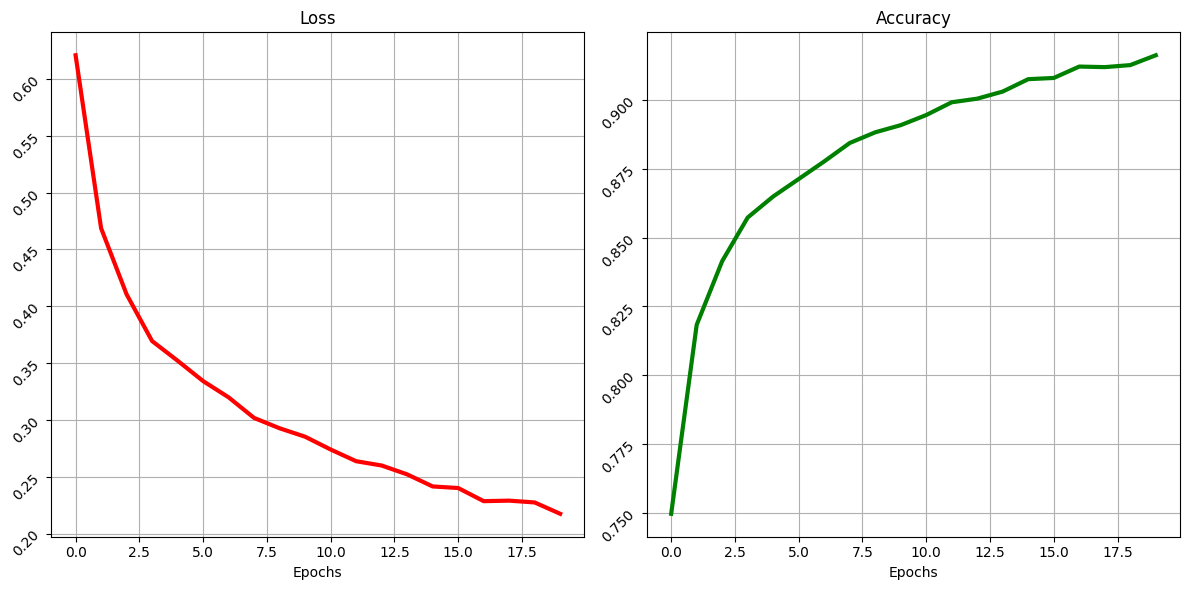

In [14]:
# plot accuracy and loss change per epoch
plot_topics = ['loss', 'accuracy']
colors = ['red', 'green']
plt.figure(figsize = (12,6))
for i in range(len(plot_topics)):
    plt.subplot(1,2,i+1)
    sns.lineplot(history.history[plot_topics[i]], color = colors[i], lw = 3)
    plt.title(plot_topics[i].capitalize())
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.yticks(rotation = 45)
plt.tight_layout()
plt.show();

In [ ]:
# plot model schema, output in model_schema.png
keras.utils.plot_model(model, show_shapes = True, to_file = 'model_schema.png')

In [23]:
# functions for plotting results
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis = -1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset, num):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        visualize([image[0], mask[0], create_mask(pred_mask)])

1/1 [==============================] - 0s 35ms/step


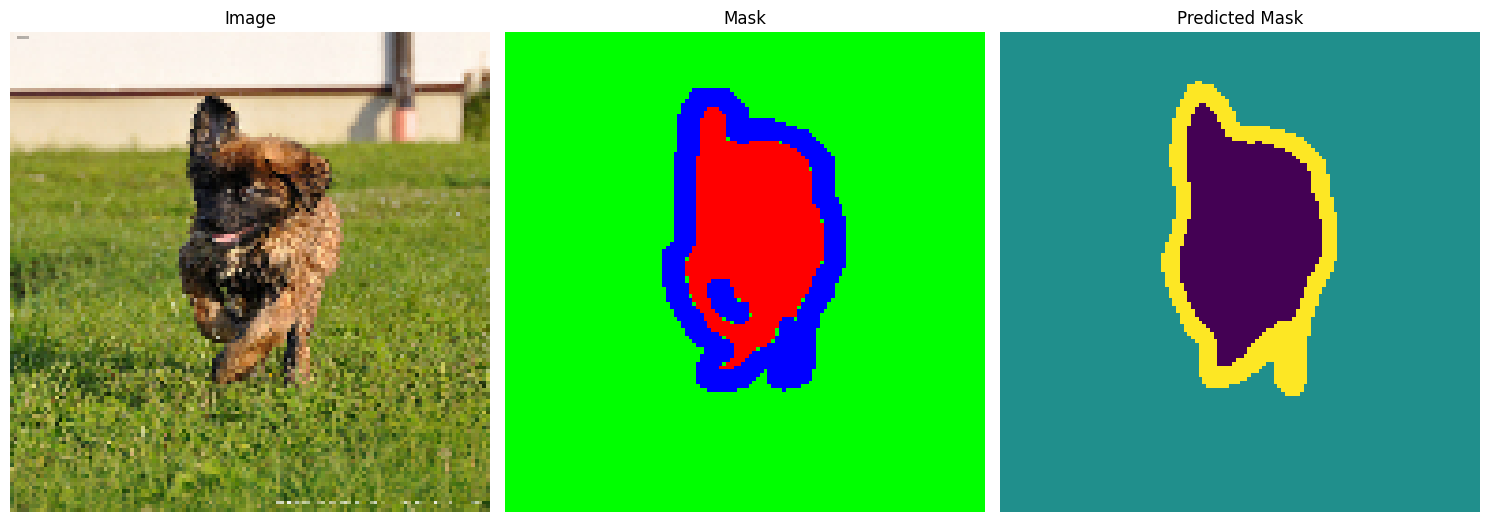

1/1 [==============================] - 0s 28ms/step


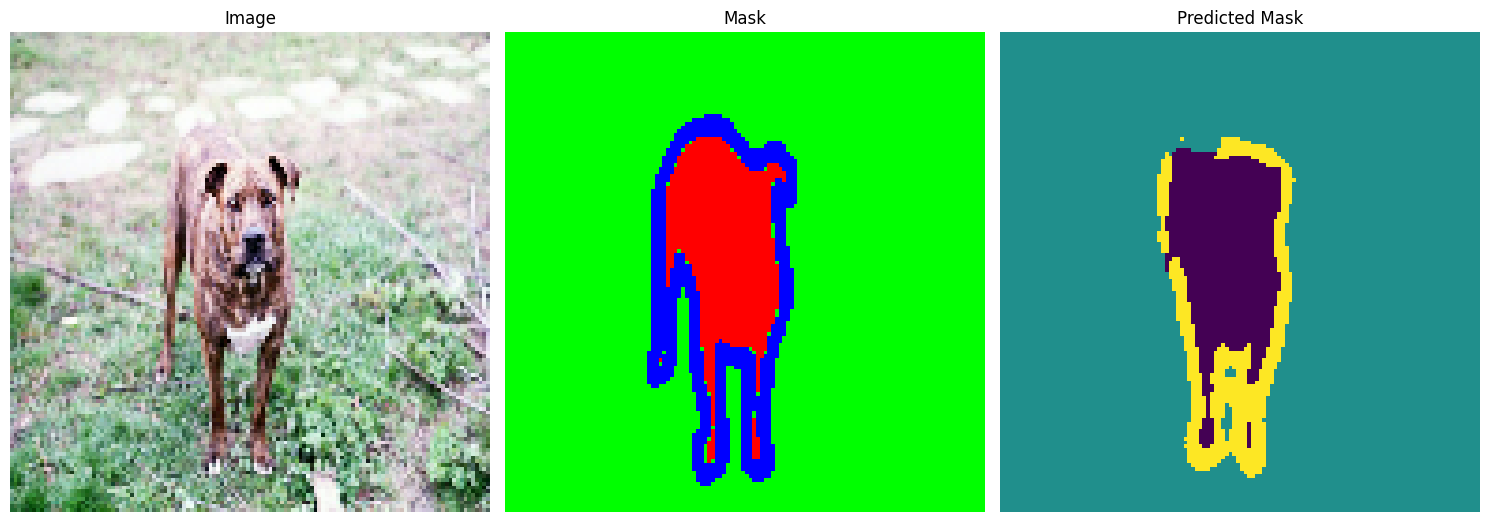

1/1 [==============================] - 0s 29ms/step


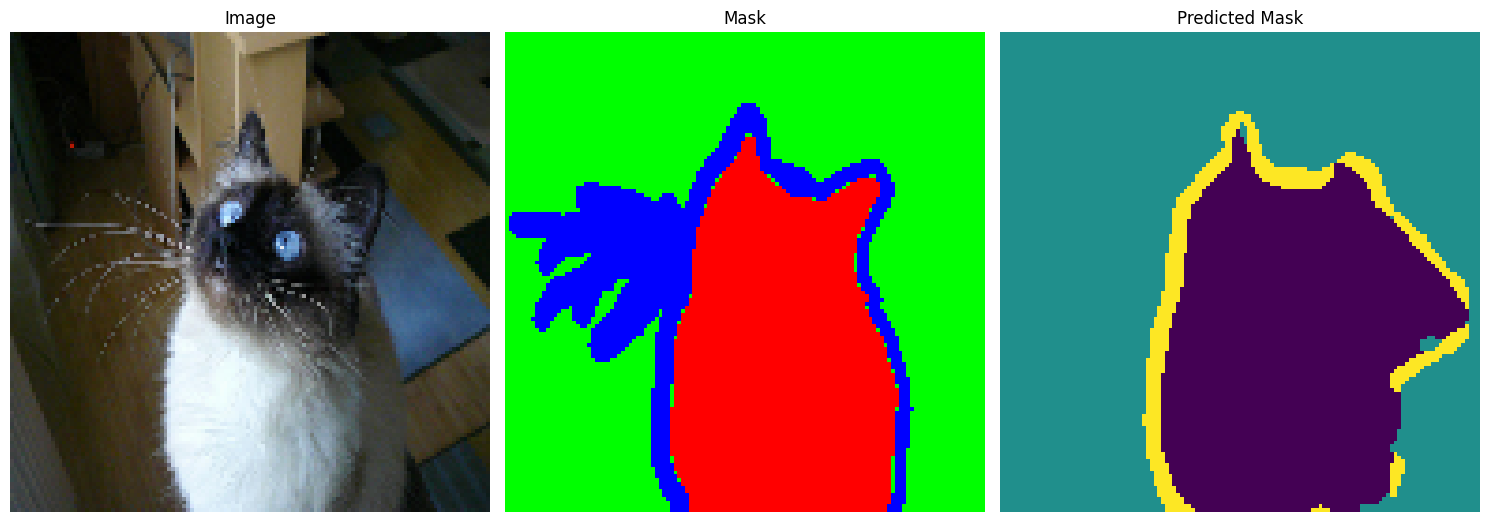

In [24]:
show_predictions(test_batches, 3)